In [ ]:
# Welcome to your new notebook
# Type here in the cell editor to add code!
!pip install prophet

StatementMeta(, 7cba71b2-ed06-4536-893e-cff94111d9af, 3, Finished, Available, Finished)

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import month, year, col
from prophet import Prophet
import pandas as pd

StatementMeta(, 7cba71b2-ed06-4536-893e-cff94111d9af, 4, Finished, Available, Finished)

StatementMeta(, 7cba71b2-ed06-4536-893e-cff94111d9af, 5, Finished, Available, Finished)

19:55:34 - cmdstanpy - INFO - Chain [1] start processing
19:55:35 - cmdstanpy - INFO - Chain [1] done processing
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/prophet/plot.py:

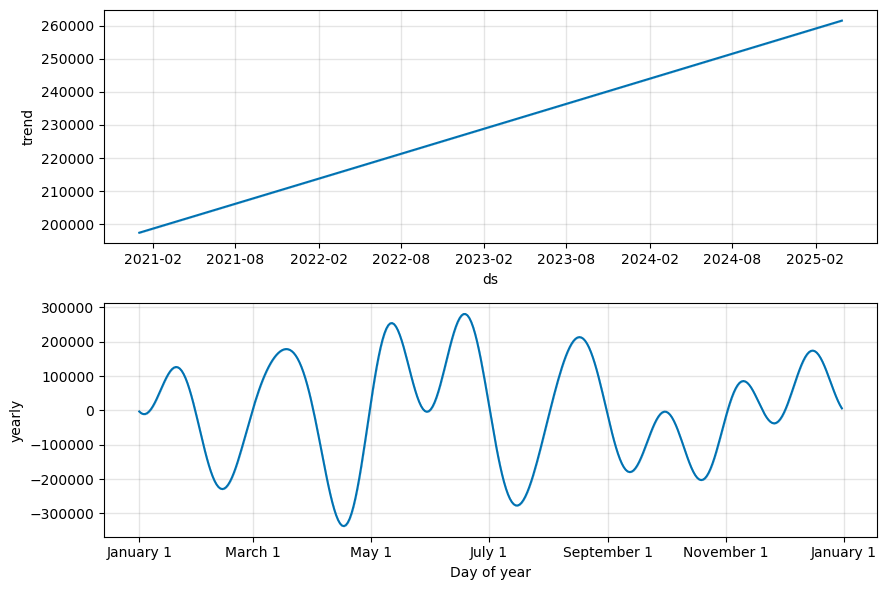

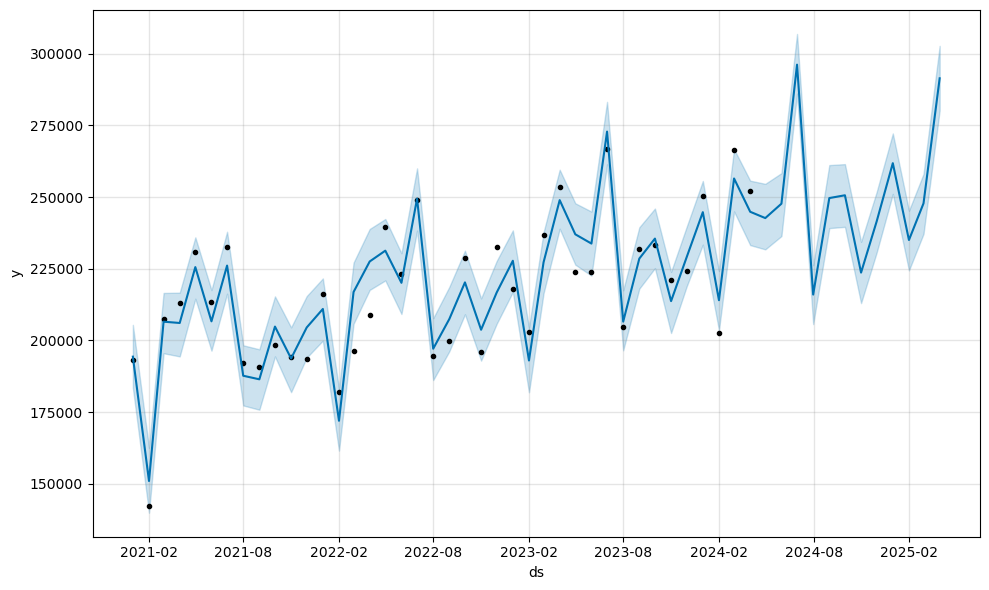

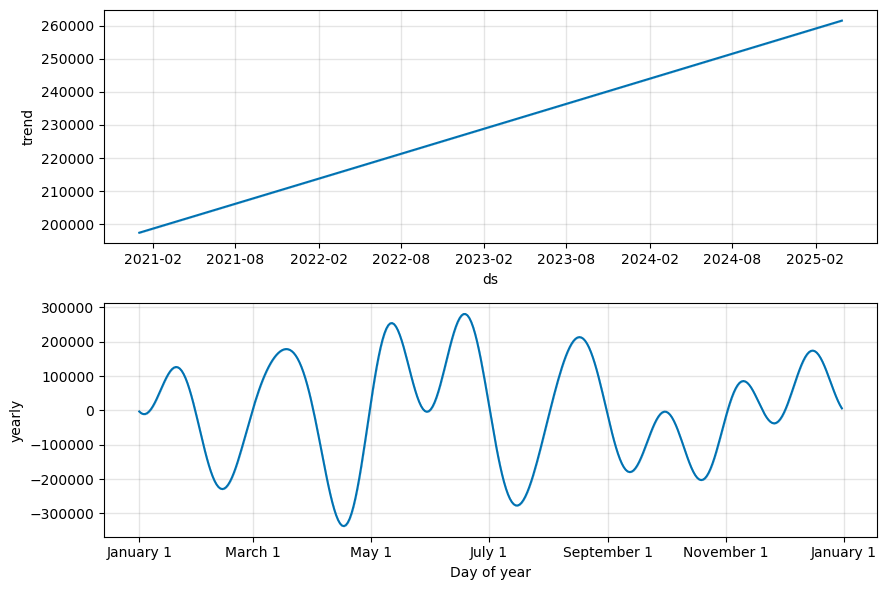

In [ ]:
# Initialize Spark session
spark = SparkSession.builder.appName("Prophet Forecasting").getOrCreate()

# Load data from your specific Spark table
df = spark.sql("SELECT * FROM lh_FAIAD.Invoices i JOIN lh_FAIAD.InvoiceLineItems il ON i.InvoiceID = il.InvoiceID")

# Aggregate data to monthly level
monthly_df = df.withColumn("Month", month("InvoiceDate"))\
.withColumn("Year", year("InvoiceDate"))\
.groupBy("Year", "Month")\
.sum("Quantity")\
.orderBy("Year", "Month")

# Convert to Pandas DataFrame and prepare for Prophet
pandas_df = monthly_df.toPandas()
pandas_df['ds'] = pd.to_datetime(pandas_df[['Year', 'Month']].assign(DAY=1))
pandas_df['y'] = pandas_df['sum(Quantity)']

# Fit the Prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=False,daily_seasonality=False)
model.fit(pandas_df[['ds', 'y']])

# Create a DataFrame for future predictions (e.g., next 12 months)
future = model.make_future_dataframe(periods=12, freq='M')

# Forecast
forecast = model.predict(future)

# Plotting the forecast
model.plot(forecast)
model.plot_components(forecast)